In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from skmap.misc import find_files, GoogleSheet, ttprint
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor 
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer#, root_mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
# from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
from trees_rf import TreesRandomForestRegressor
from model_fit import read_features, cfi_calc, parameter_fine_tuning, calc_ccc, separate_texture_data, rscfi 
from model_fit import accuracy_plot, plot_top_features, pdp_hexbin, plot_histogram, calc_metrics, accuracy_strata_plot
import warnings
warnings.filterwarnings('ignore')
import os
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import json
from datetime import datetime

folder_path = '/mnt/ripley/global_soc/scikit-map/global-soil-mapping'
# version = "20250204"
version = "20250523"
prop_list = ['texture1', 'texture2']
transforms_dict = {
    'texture1': None,
    'texture2': None,
}

min_convs_num = 60
max_convs_num = 120


# Separate Calibration (Cal), Train, and Test Data

Perform this separation **only once**, then save and read the separated data to ensure reproducibility.

#### Data ratio:
- **When data is limited**: Maintain the ratio between calibration, train, and test sets as `1:8:1`.
- **When data is abundant**: Allocate around **8,000 samples** for calibration and **6,000 samples** for testing.

#### How:
- **Strata with very few samples** (`count < 3`): Randomly assign samples to a set.
- **Strata with few samples** (`3 ≤ count < 10`): Distribute samples evenly across the sets.
- **Strata with sufficient samples** (`count ≥ 10`): Assign samples according to the specified ratio.


In [2]:
df = pd.read_parquet(f'{folder_path}/material/soil_pnts_organized_v{version}.pq')

separate_texture_data('texture1', 'texture2', f'{folder_path}/textures', version, df, strata_col = ['hzn_dep_bin','clm_class'])


Size: Calibration 8004, Training 348601, Test 6005
Ratio: Calibration 0.02, Training 0.96, Test 0.02
Sum 362610, Dataframe size 362610


# Model calibration

In [3]:
with open(f'{folder_path}/material/soil_cov_no.bimonthly.landsat_v{version}.json', "r") as file:
    covar_cols = json.load(file)
print('total cov number: ', len(covar_cols))

for prop in prop_list:
    print(f'\n{prop}--------------------------------------------------------------')
    space = transforms_dict[prop]
    output_folder = f'{folder_path}/textures'
    os.makedirs(output_folder, exist_ok=True)
    tgt = prop
    
    
    # read existing results
    cal = pd.read_parquet(f'{output_folder}/data_cal_textures_v{version}.pq')
    
    # # feature selection
    print('feature selection********************')
    cfi = cfi_calc(cal, tgt, prop, space, output_folder, version, covar_cols) # produce
    


total cov number:  270

texture1--------------------------------------------------------------
feature selection********************
start bootstrap on different subset...
[11:25:45] 0 iteration, training size: 5602
[11:26:25] 1 iteration, training size: 5602
[11:27:04] 2 iteration, training size: 5602
[11:27:44] 3 iteration, training size: 5602
[11:28:16] 4 iteration, training size: 5602
[11:28:54] 5 iteration, training size: 5602
[11:29:27] 6 iteration, training size: 5602
[11:30:06] 7 iteration, training size: 5602
[11:30:44] 8 iteration, training size: 5602
[11:31:17] 9 iteration, training size: 5602
[11:31:56] 10 iteration, training size: 5602
[11:32:33] 11 iteration, training size: 5602
[11:33:06] 12 iteration, training size: 5602
[11:33:39] 13 iteration, training size: 5602
[11:34:12] 14 iteration, training size: 5602
[11:34:50] 15 iteration, training size: 5602
[11:35:23] 16 iteration, training size: 5602
[11:36:01] 17 iteration, training size: 5602
[11:36:40] 18 iteration, tra

total cov number:  270

texture1--------------------------------------------------------------
[11:49:31] processing -5.522160304574865e-05 ...
[11:49:40] processing 0.0 ...
[11:49:50] processing 0.00014477839695425135 ...
[11:49:59] processing 0.00034477839695425133 ...
[11:50:06] processing 0.0005447783969542513 ...
[11:50:12] processing 0.0007447783969542512 ...
[11:50:17] processing 0.0009447783969542513 ...
[11:50:21] processing 0.0011447783969542513 ...
[11:50:24] processing 0.0013447783969542512 ...
[11:50:26] processing 0.0015447783969542513 ...
[11:50:29] processing 0.0017447783969542514 ...
[11:50:31] processing 0.0019447783969542515 ...
[11:50:33] processing 0.002144778396954251 ...
[11:50:34] processing 0.002344778396954251 ...
[11:50:36] processing 0.0025447783969542513 ...
[11:50:38] processing 0.002744778396954251 ...
[11:50:39] processing 0.002944778396954251 ...
[11:50:41] processing 0.003144778396954251 ...
[11:50:43] processing 0.0033447783969542512 ...
[11:50:45] pr

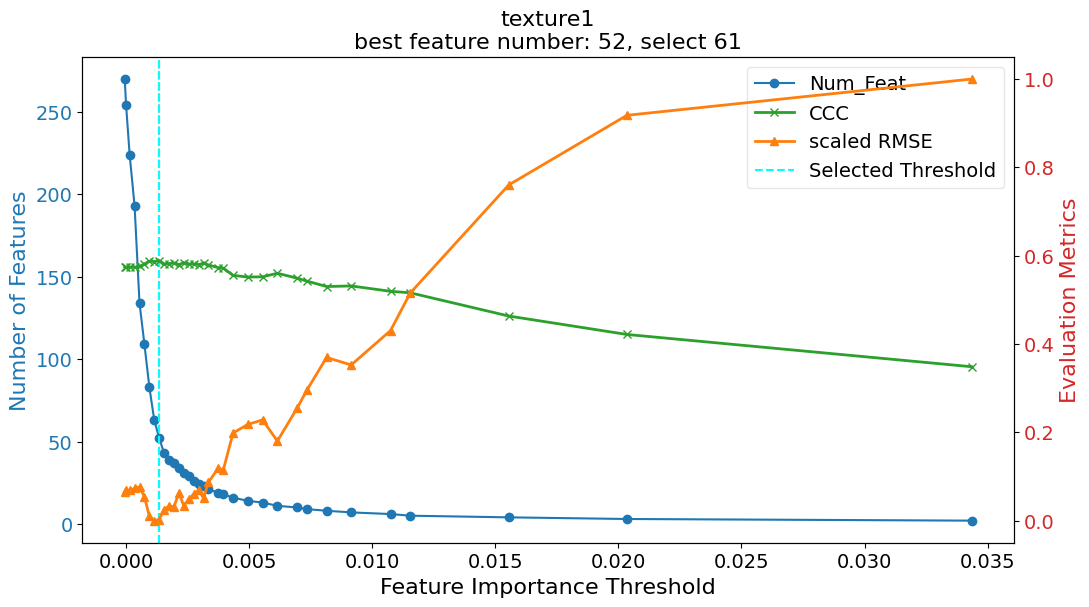

parameter fine tuning****************
[11:50:56] ----------------------rf------------------------
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8004
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 135
n_resources: 98
Fitting 5 folds for each of 135 candidates, totalling 675 fits
----------
iter: 1
n_candidates: 45
n_resources: 294
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 2
n_candidates: 15
n_resources: 882
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 5
n_resources: 2646
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 2
n_resources: 7938
Fitting 5 folds for each of 2 candidates, totalling 10 fits

texture2--------------------------------------------------------------
[11:51:29] processing -0.0002541659510047 ...
[11:51:39] processing -5.416595100469999e-05 ...
[11:51:49] process

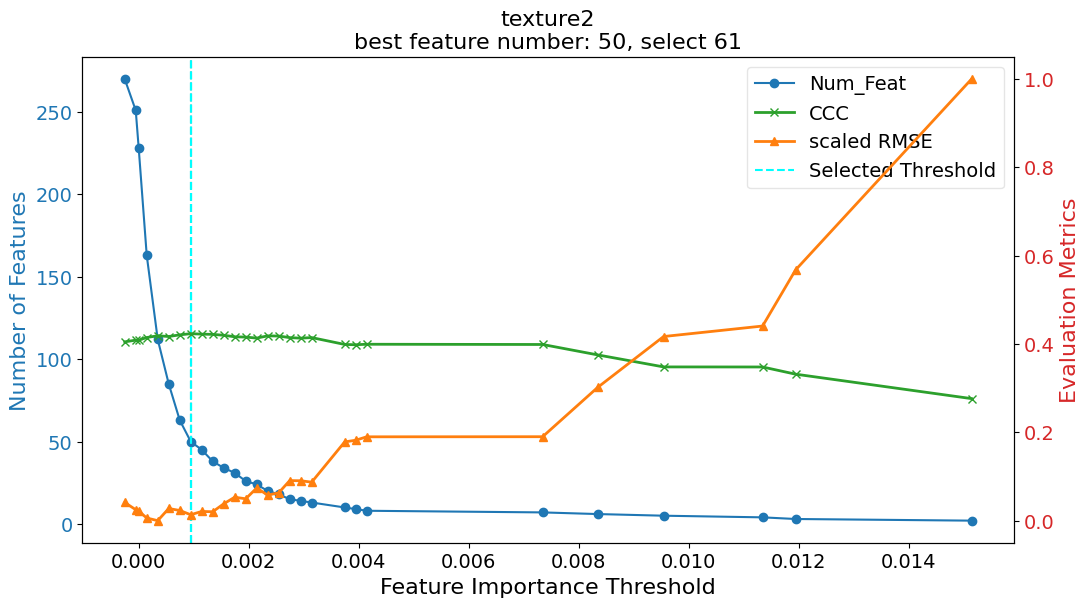

parameter fine tuning****************
[11:52:45] ----------------------rf------------------------
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 98
max_resources_: 8004
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 135
n_resources: 98
Fitting 5 folds for each of 135 candidates, totalling 675 fits
----------
iter: 1
n_candidates: 45
n_resources: 294
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 2
n_candidates: 15
n_resources: 882
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 5
n_resources: 2646
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 2
n_resources: 7938
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [4]:
with open(f'{folder_path}/material/soil_cov_no.bimonthly.landsat_v{version}.json', "r") as file:
    covar_cols = json.load(file)
print('total cov number: ', len(covar_cols))

for prop in prop_list:
    print(f'\n{prop}--------------------------------------------------------------')
    space = transforms_dict[prop]
    output_folder = f'{folder_path}/textures'
    os.makedirs(output_folder, exist_ok=True)
    
    tgt = prop
        
    cal = pd.read_parquet(f'{output_folder}/data_cal_textures_v{version}.pq')
    cfi = pd.read_csv(f'{output_folder}/feature_cfi_{prop}_v{version}.csv') # read in
    covs = rscfi(cal, tgt, prop, space, output_folder, version, covar_cols, cfi, min_convs_num, max_convs_num, step_size=0.0002) # produce
         
    
    # ## read in existing results
    # covs = read_features(f'{output_folder}/feature_selected_{prop}_v{version}.txt') # read in
    ## parameter fine-tuning
    print('parameter fine tuning****************')
    models, model_names = parameter_fine_tuning(cal, covs, tgt, prop, output_folder, version)